# Classificação - EDA - Part. 1 e Part. 2 (em andamento)

Neste notebook faremos a EDA Parte 1.

## Análise de sentimento com SVM, FCC e LSTM.

## Introdução


### Definição do problema

Criar um modelo de machine learning para previsão de sentimento em comentários do twiiter.


### Verificação dos dados

Dados públicos disponíveis no [kaggle](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis).

Conforme [documentação](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) "Existem três classes neste conjunto de dados: Positivo, Negativo e Neutro. Consideramos mensagens que não são relevantes para a entidade (ou seja, irrelevantes) como Neutras".

"Este é um conjunto de dados de análise de sentimento em nível de entidade do Twitter. Dada uma mensagem e uma entidade, a tarefa é avaliar o sentimento da mensagem em relação à entidade" [fonte](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis):

### Observação dos dados

Conforme [documentação](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) temos 4 sentimentos associados às respectivas mensagens.

Ainda, pode existir (será confirmado na exploração dos dados) um desbalanceamento entre as frequêcias das classes.

## Projeto


### Bibliotecas


In [1]:
## Definindo nível de warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# instalando pipline de detecção de linguagem
!pip install -q spacy-language-detection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
#imports
import warnings
warnings.filterwarnings('ignore')

## data exploration/visuaization stack
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##
import kagglehub
import shutil
from random import sample
from tqdm import  tqdm

## EDA e pré-processamento
import spacy
import nltk
from nltk import word_tokenize, pos_tag
from nltk.text import sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
import string
from collections import Counter
from spacy.language import Language
from spacy_language_detection import LanguageDetector



In [4]:
# Download do dicionário spacy
!python -m spacy download en_core_web_md -q
dicionario = spacy.load('en_core_web_md')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 34.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
# Baixando piplines nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# capturando stopwords únicas do pacote nltk
stop = set(nltk.corpus.stopwords.words('english'))

### Carga dos dados

In [7]:
# Download latest version
warnings.filterwarnings("ignore")
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'twitter-entity-sentiment-analysis' dataset.
Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [8]:
shutil.move("/kaggle/input/twitter-entity-sentiment-analysis", ".")

OSError: [Errno 30] Read-only file system: '/kaggle/input/twitter-entity-sentiment-analysis'

In [9]:
#carregando dados
df_total = pd.read_csv('/content/twitter-entity-sentiment-analysis/twitter_training.csv', header=None, usecols=[2, 3], nrows=35000)

In [10]:
# Obtendo atributos necessários para EDA Part. 1
df_total.columns = ['sentiment', 'text']

In [11]:
# Visualizando
df_total.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


### Data Wrangling

#### Análise exploratória

**Metadados**

In [12]:
# Visualizando metadadoss
df_total.shape

(35000, 2)

Limitamos a amostra em 35000 por questões de hardware.

OBS: foram dispensadas técnicas de amostragem, diante do caráter apenas pedagógico do presente estudo.

In [13]:
# casting do tipo
df_total['text'] = df_total['text'].astype(dtype=str)

In [14]:
# Tipo de dados
df_total.dtypes

,0
sentiment,object
text,object


In [15]:
df_total['sentiment'].describe()

,sentiment
count,35000
unique,4
top,Positive
freq,10812


In [16]:
df_total['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

Total de 4 sentimentos, sendo o mais frequente (10812) o sentimento "Positive".

OBS: o balanceamento das classes será análisado adiante, no pré-processamento para o treinamento do modelo.

In [17]:
# Verificando presençã de na's

df_total.isna().any()

,0
sentiment,False
text,False


In [18]:
# observando uma amostra de texto para cada sentimento
for sentimento in df_total['sentiment'].unique():

  print("-"*50)
  print(f"Amostra do sentimento: {sentimento}")

  print(df_total[df_total['sentiment'] == sentimento].sample(5))



--------------------------------------------------
Amostra do sentimento: Positive
      sentiment                                               text
1201   Positive               Hmmmmmmmm, that could be really good
21518  Positive                           That would be fantastic.
18091  Positive  I can't wait for my brother to get the PS5, ju...
21830  Positive                         one of my favorite records
29176  Positive  2 The The Good Place and Apex Legends.. I woul...
--------------------------------------------------
Amostra do sentimento: Neutral
      sentiment                                               text
16820   Neutral  While the store is in turmoil right now, with ...
24150   Neutral  "Google Steals Content From Honest Businesses"...
27467   Neutral  Shop Price Creed 8 Flag offers in ebay. New in...
30029   Neutral                             . u hate to see people
18750   Neutral  I other x humbly submit a toast to Nicholas Al...
-------------------------------

Conforme já documentado, foi utilizado um dataset público.

Desta forma, a etiquetagem dos sentimentos correspondentes não é garantida, o que, a propósito, pode comprometer o aprendizado de padrões para cada sentimento durante o treinamento, e, por conseguinte, as previsões.

Renova-se, portanto, a orientação de que o prosente projeto visa apenas o caráter pedagógico.

##### **Parte 1** Análise inicial

Nesta etapa conheceremos algumas estatísticas básicas, tais como:



1.   Contagem de caracteres;
2.   Contagem de palavras;
3.   Contagem de sentenças;
4.   Cumprimento médio das palavras;
5.   Presença de outliers e ruídos;
6.   Limpeza com expressão regular e lemmatização;
7.   Conhecer o corpus a ser tokenizado (na fase de pré-processamento para ML);
8.   Identificação de linguagem



**Funções**

In [19]:
# Classe para limpeza de texto - depois de limpar o texto, será criado o corpus (objeto contendo toda as palavras)
def ProcessaTexto(text) -> str:
  """
    Realiza a limpeza e normalização de um texto, aplicando remoção de ruído,
    tratamento com expressões regulares e lematização via spaCy.

    Essa função é utilizada como etapa de pré-processamento antes da criação
    do *corpus*—conjunto de palavras limpas que servirá de entrada para análises,
    modelos estatísticos ou algoritmos de NLP.

    Etapas aplicadas:
    1. Remoção de URLs.
    2. Remoção de menções (ex: @usuario).
    3. Remoção de caracteres não ASCII.
    4. Remoção de pontuação.
    5. Processamento via pipeline spaCy.
    6. Lematização e remoção de stopwords.

    Parâmetros
    ----------
    text : str
        Texto bruto a ser limpo e normalizado.

    Retorno
    -------
    str
        Texto processado contendo apenas lemas (lemmas) em minúsculas,
        sem stopwords, pontuações, URLs ou caracteres especiais.

    Observações
    -----------
    - A função depende de um objeto spaCy previamente carregado (ex.: `dicionario = nlp`).
    - As expressões regulares removem padrões comuns de redes sociais.
    - O resultado final é adequado para criação de corpus, vetorização e análise textual.
  """

  # eliminando referências à URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)

  # elimando menções
  text = re.sub(r"\@\w+\|\#\w\+", "", text)

  #Removendo caracteres não ASCII (não romanos)
  text = re.sub(r"[^\x00-\x7F]+", "", text)

  #Tratando Pontuação
  text = text.translate(str.maketrans("", "", string.punctuation)) # não substitui nada, apenas remove as pontuações
  # mktrans cria a tabela
  # translate faz a "tradução"

  # Aplicando pipline spacy - convertendo em doc
  text = dicionario(text)

  # aplicando pipline
  tokens = [token.lemma_.lower().strip() for token in text if not token.is_stop]

  return " ".join(tokens)


# retorna linguagem identificada na instância
def language_identify(text) -> str:
    """
    Identifica o idioma predominante em um texto com base na quantidade de
    stopwords encontradas para cada idioma disponível no NLTK.

    O método utiliza uma abordagem simples:
    - Divide o texto em tokens.
    - Para cada idioma suportado pelo corpus de stopwords do NLTK:
        * Carrega o conjunto de stopwords do idioma.
        * Compara com o conjunto de palavras do texto.
        * Conta quantas stopwords aparecem no texto.
    - Retorna o idioma que possui o maior número de stopwords em comum.

    Parâmetros
    ----------
    text : str
        Texto que se deseja identificar o idioma.

    Retorno
    -------
    str
        O código do idioma (ex.: 'english', 'portuguese', 'spanish') que obteve
        maior interseção de stopwords com o texto informado.

    Observações
    -----------
    - A função depende do corpus `stopwords` do NLTK.
    - O método funciona melhor para textos com volume razoável.
    - Para textos muito curtos, a precisão pode ser limitada.
    - A lógica é baseada em interseção de conjuntos, portanto é rápida e eficiente.
    """

    languages_ratio = {}

    # Tokeniza texto por espaço
    instance_corpus = text.split()

    for language in stopwords.fileids():

        # conjunto de stopwords do idioma
        stopwords_set = set(stopwords.words(language))

        # conjunto de tokens únicos do texto
        words_set = set(instance_corpus)

        # interseção entre stopwords e tokens do texto
        common_elements = words_set.intersection(stopwords_set)

        # salva a quantidade de stopwords encontradas
        languages_ratio[language] = len(common_elements)

    # retorna o idioma com maior pontuação
    identify_language = max(languages_ratio, key=languages_ratio.get)

    return identify_language



def boxplot_chart(dados: pd.DataFrame, atributo: str) -> None:

  """
    Gera um grid de boxplots para comparar a distribuição dos
    atributos numéricos entre diferentes classes de sentimento.

    A função utiliza Seaborn e Matplotlib para criar uma visualização clara e
    organizada, com uma paleta de cores específica para cada sentimento.

    Funcionamento
    -------------
    - Obtém todas as classes únicas da coluna 'sentiment'.
    - Cria uma grid de subplots com 1 linha e N colunas.
    - Para cada classe de sentimento:
        * Filtra o dataframe para aquela classe.
        * Plota um boxplot do atributo fornecido.
        * Aplica cor específica conforme o dicionário `palette_sentiments`.
        * Ajusta transparência, títulos, labels e layout.

    Parâmetros
    ----------
    dados : pandas.DataFrame
        DataFrame contendo uma coluna denominada 'sentiment' e pelo menos um
        atributo numérico a ser plotado.

    atributo : str
        Nome da coluna numérica cujo boxplot será gerado para cada classe
        de sentimento.

    Retorno
    -------
    None
        A função exibe o gráfico, mas não retorna valores.

    Paleta Utilizada
    ----------------
    - Positive   → Verde  (#4CAF50)
    - Negative   → Vermelho (#F44336)
    - Neutral    → Cinza (#9E9E9E)
    - Irrelevant → Azul claro (#03A9F4)

    Observações
    -----------
    - A função cria uma figura de tamanho fixo (6x5).
    - Cada boxplot é exibido em sua própria coluna da grid.
    - A transparência (alpha) é aplicada manualmente nos patches do Seaborn.
    - `plt.tight_layout()` ajusta automaticamente o espaçamento interno.
    - `plt.suptitle()` define o título geral acima dos subplots.
  """

  plt.figure(figsize=(6,5))

  sns.set_style("whitegrid", {'grid.linestyle':':'})

  classes = dados['sentiment'].unique()

  palette_sentiments = {
        'Positive': '#4CAF50',
        'Negative': '#F44336',
        'Neutral': '#9E9E9E',
        'Irrelevant': '#03A9F4'
    }

  for i, classe in enumerate(classes):

    # 1 linha, 4 colunas, na posição i + 1
    plt.subplot(1, len(classes), i + 1)

    ax = sns.boxplot(y = dados.loc[dados['sentiment'] == classe, atributo], color = palette_sentiments.get(classe, "#CCCCCC"))


    for patch in ax.artists:
      patch.set_alpha(.85)

    plt.title(classe)

    plt.ylabel("")

    plt.yticks(size = 8)

    plt.suptitle(f"Distribuição - {atributo} por sentimento", fontsize = 14, y = 1.02, fontweight = 'bold')

    plt.tight_layout()


def drop_outliers(dados: pd.DataFrame, atributo: str, sentiment_hue: list, limiar: int = 3) -> pd.DataFrame:


  """
    Remove outliers de um atributo numérico para cada classe de sentimento
    especificada, utilizando o método do *Z-Score* (pontos fora de `limiar`
    desvios-padrão da média).

    O processo é realizado individualmente para cada categoria presente em
    `sentiment_hue`, garantindo que os outliers sejam removidos de forma
    segmentada — evitando que classes maiores distorçam o cálculo.

    Funcionamento
    -------------
    Para cada sentimento especificado:
      1. Filtra os registros daquele sentimento.
      2. Calcula média e desvio padrão do atributo dentro da classe.
      3. Calcula o Z-Score absoluto:
            z = |valor - média| / desvio_padrao
      4. Remove registros cujo Z-Score seja maior ou igual ao limiar.
      5. Atualiza o DataFrame para próximas iterações.

    Parâmetros
    ----------
    dados : pandas.DataFrame
        DataFrame contendo ao menos:
        - uma coluna chamada 'sentiment'
        - o atributo numérico a ser filtrado.

    atributo : str
        Nome da coluna numérica da qual os outliers serão removidos.

    sentiment_hue : list
        Lista contendo as categorias de sentimento sobre as quais a filtragem
        de outliers deve ser aplicada (ex.: ['Positive', 'Negative']).

    limiar : int, default=3
        Valor limite do Z-Score. Pontos com |Z| >= limiar serão removidos.
        O padrão de 3 representa o chamado *método dos 3 sigmas*.

    Retorno
    -------
    pandas.DataFrame
        Novo DataFrame contendo apenas os registros que passaram pelo filtro
        de outliers por sentimento.

    Observações
    -----------
    - Outliers são removidos separadamente para cada sentimento.
    - `dados = dados[...]` garante que o DataFrame seja atualizado a cada ciclo.
    - `copy()` evita avisos de *SettingWithCopyWarning*.
    - Se o desvio padrão for 0, todos os valores da classe serão mantidos (evita
      divisão por zero).
  """
  for sentiment in sentiment_hue:

    mask = dados['sentiment'] == sentiment
    media = dados.loc[mask, atributo].mean()
    desvio_padrao = dados.loc[mask, atributo].std()

    scores = (dados.loc[mask, atributo] - media).abs() / desvio_padrao

    dados = dados[~mask | (scores < limiar)].copy()

  return dados





## Classe para detecção de linguagem
class LanguageDetectorService:
    """
    Serviço para detecção de idioma em texto, utilizando a biblioteca spaCy
    e o componente 'LanguageDetector'.

    Esta classe carrega um modelo spaCy e adiciona o pipeline de detecção de idioma
    durante a inicialização, armazenando o modelo configurado como um atributo da instância.
    """

    def __init__(self):

        self._set_attributes()

    def __get_lang_detector(self, nlp, name):
        """
        Função de fábrica para o componente LanguageDetector do spaCy.

        Parâmetros:
            nlp (Language): Objeto Language do spaCy.
            name (str): Nome do componente no pipeline.

        Retorna:
            LanguageDetector: Uma instância do detector de idioma.
        """
        return LanguageDetector(seed=42)

    def _set_attributes(self):
        """
        Configura e adiciona o modelo spaCy e o pipeline de detecção de idioma.

        Carrega o modelo 'en_core_web_md', registra a fábrica do componente
        'language_detector' e adiciona o componente ao pipeline. O modelo
        configurado é então armazenado no atributo de instância 'nlp_model'.
        """
        nlp_model = spacy.load("en_core_web_md")

        Language.factory("language_detector", func=self.__get_lang_detector)

        nlp_model.add_pipe('language_detector', last=True)

        setattr(self, 'nlp_model', nlp_model)

    def return_language(self, text: str) -> str:
        """
        Detecta e retorna o idioma de um determinado texto.

        O idioma detectado é uma string contendo o código ISO 639-1 (ex: 'en', 'pt').

        Parâmetros:
            self: A instância da classe.
            text (str): O texto para o qual o idioma deve ser detectado.

        Retorna:
            str: O código do idioma detectado (ex: 'en').
        """

        nlp_model = getattr(self, 'nlp_model')

        doc = nlp_model(text) # Não é necessário 'text=text'

        language = doc._.language

        return language['language']

In [20]:
# Contagem de caracteres (menor unidade de uma string)
df_total['char_count'] = df_total['text'].map(lambda x: len(x))

In [21]:
# Contagem de palavras
df_total["word_count"] = df_total["text"].map(lambda x: len(x.split()))

In [22]:
# Contagem de sentenças (expressões terminadas com pontuação, como '.', ';', '?')
df_total['sent_count'] = df_total['text'].map(lambda x: len(sent_tokenize(x)))


In [23]:
# Cumprimento médio das palavras
df_total["avg_world_len"] = df_total["text"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

In [24]:
# Cumprimento médio das sentenças
df_total["avg_sent_len"] = df_total['text'].map(lambda x: np.mean([len(sen.split()) for sen in sent_tokenize(x)]))

**Visualizando estatísticas**

In [25]:
df_part1 = df_total[['sentiment', 'char_count', 'word_count', 'sent_count', 'avg_world_len', 'avg_sent_len']]

In [26]:
df_part1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
char_count,35000.0,102.306171,78.208479,1.0,42.0,83.000000,144.000000,727.0
word_count,35000.0,18.274457,14.275245,0.0,7.0,15.000000,26.000000,198.0
sent_count,35000.0,1.928800,1.589080,0.0,1.0,1.000000,2.000000,25.0
avg_world_len,34929.0,4.894540,5.179978,1.0,4.0,4.517241,5.166667,396.0
avg_sent_len,34929.0,10.918195,8.816370,1.0,5.0,9.000000,14.000000,198.0


**Inicialmente**, é possível concluir pela existência de ruídos nos dados (instâncias com apenas 1 caracter), bem como existência de outliers (como sugerem os máximos muito afastados do segundo e terceiro quartis).

Ainda, pode-se perceber uma assimetria leve à direta, quanto a distribuição.

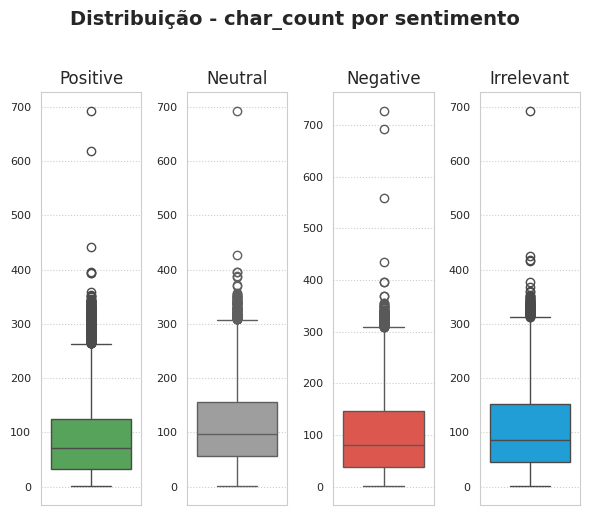

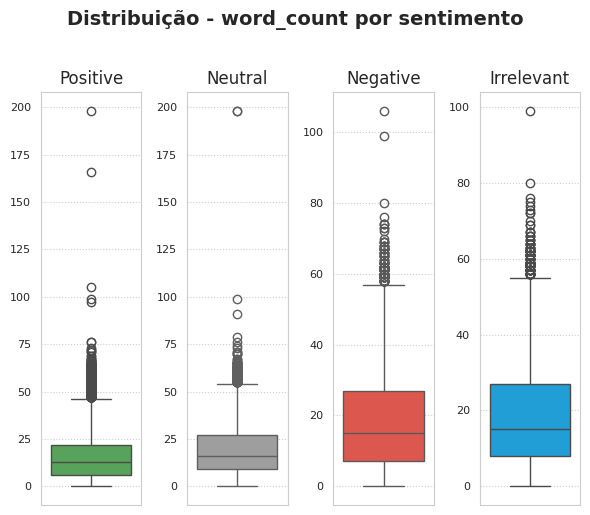

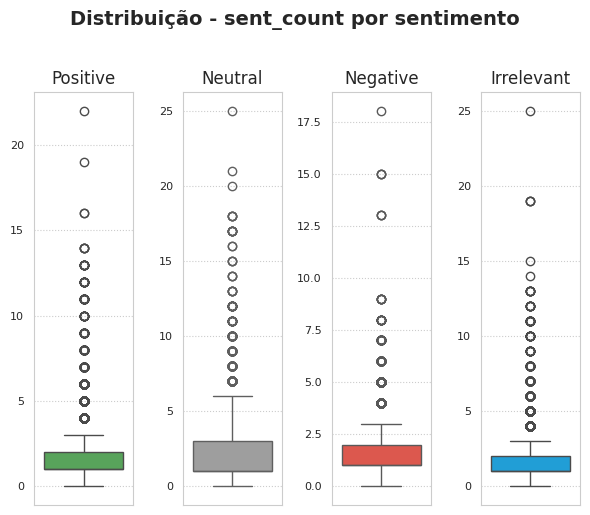

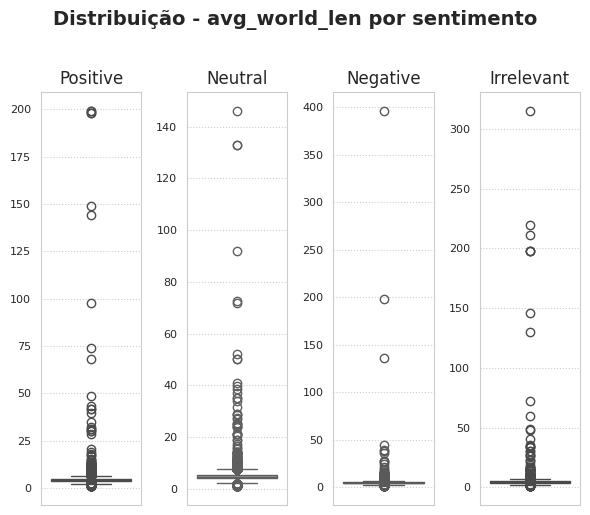

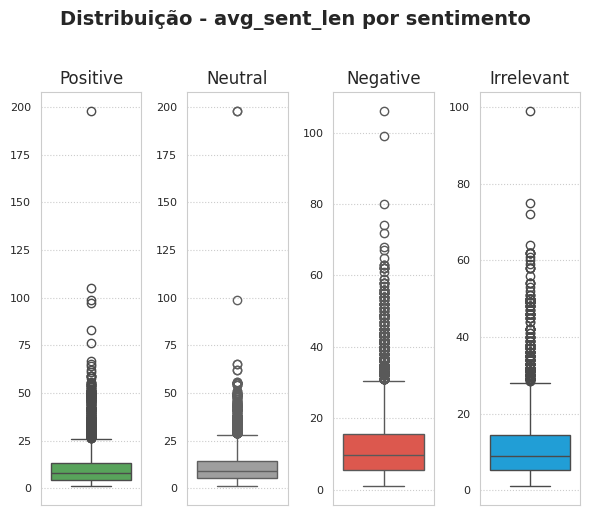

In [27]:
#Identificação de ruídos e outliers - boxplot por classe

attributes = ['char_count', 'word_count', 'sent_count', 'avg_world_len', 'avg_sent_len']

for attr in attributes:

  boxplot_chart(df_part1, atributo=attr)

**Anaĺise**

char_count: As instâncias possuem praticamente a mesma distribuição, e limite máximo do caracteres. É possível que tenha sido uma orientação seguida durante a amostragem dos dados.

word_count: Igualmente, as distribuições são semelhantes. As categorias 'Positive' e 'neutral' possuem outliers com 200 palavras, mas, podemos ver que a concentração e posição dos demais ponto de dados são semelhantes.


sent_count: Possuem mesma distribuição, o que é de se esperar, vez que se tratam de textos curtos e informais, escritos, geralmente, sem a observâncias de regras sintáticas.

avg_word_len: Não é possível realizar análise com a presença de outliers severos. Será necessára a realização de limpeza.]

avg_sent_len: A distribuição dos sentimentoss 'Positive' e 'Neutral' é semelhantes em vários aspectos, como contrentação da massa de dados, mediana, e, inclusive os outliers. O mesmo padrão se encontra quando se analisa os sentimentos 'Negative' e 'Irrelevant'. Ao se eliminar os outliers, é provãvel que vejamos a mesma concentração para todos os sentimentos.

In [28]:
# Eliminando ruídos - word_count = 1
df_total = df_total[df_total['word_count'] != 1]

In [29]:
# Eliminando char_count = 1
df_total = df_total[df_total['char_count'] > 1]

In [30]:
# Eliminando outliers - usando zscore - com cálculo separado por classe
# Começando pelo atributo word_count
df_total_outliers_droped = drop_outliers(df_total, atributo='word_count', sentiment_hue = ['Positive', 'Negative', 'Neutral', 'Irrelevant'])

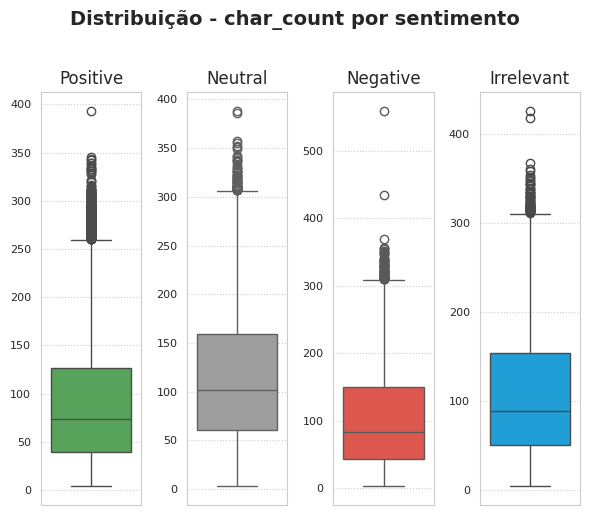

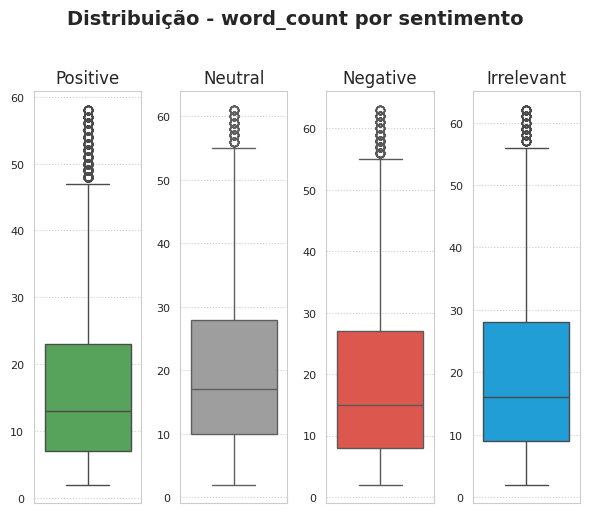

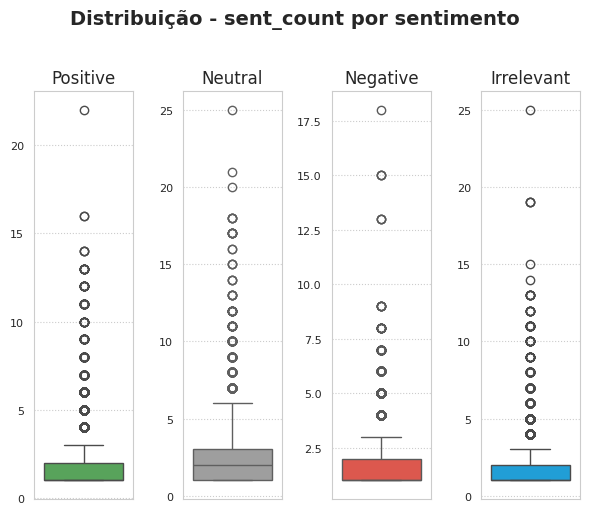

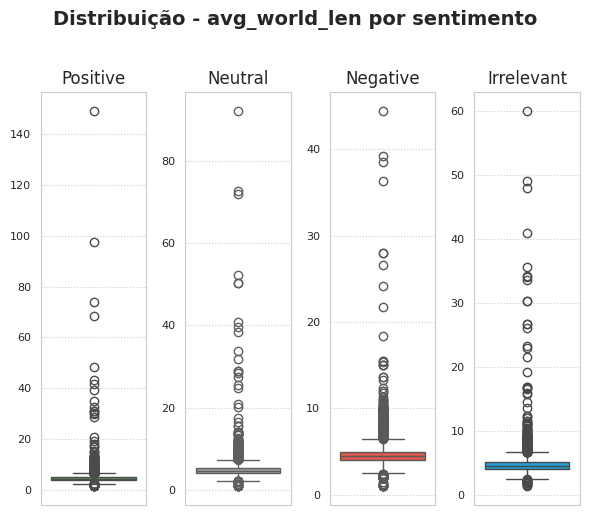

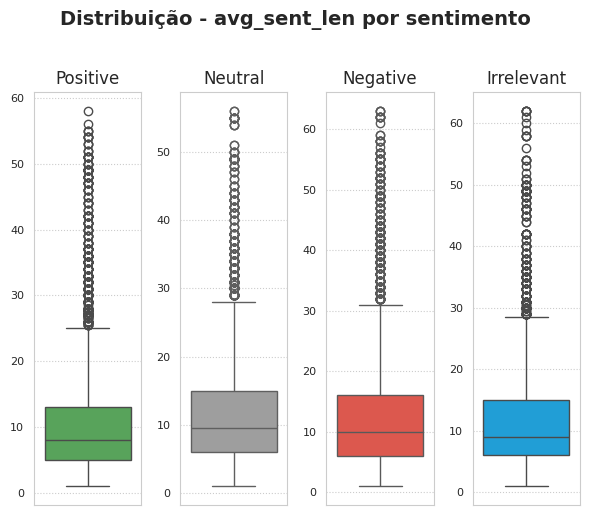

In [31]:
#Identificação de ruídos e outliers - boxplot por classe

attributes = ['char_count', 'word_count', 'sent_count', 'avg_world_len', 'avg_sent_len']

for attr in attributes:

  boxplot_chart(df_total_outliers_droped, atributo=attr)

Eliminou-se outliers consideravelmente, mas, ainda é visível a presença. A exclusão com base no z-score pode não ser a melhor opção para a exclusão de outliers nestes dados.


Ainda sim, foi possível observar que as estatísticas aprensentam variância (como quartis e mediana) em relação aos sentimentos, o que é excelente para o treinamento do modelo.

Após o término da análise exploratória e descritiva, será tomada a decisão sobre como tratar os outliers.

**Frequência de termos** do corpus


In [32]:
# Aplicando pipline de limpeza e pré-processamento de texto
df_total['text_processed'] = df_total['text'].map(ProcessaTexto)

In [33]:
# Observando texto após limpeza
df_total.sample(5)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed
23416,Neutral,""" Great experience from the entire very start....",146,29,3,4.068966,9.666667,great experience entire start say allison go...
22552,Neutral,best of everything @Mixwell as he announces he...,131,27,4,3.888889,6.750000,good mixwell announce s leave cs fort valoran...
24807,Negative,Imma just say this here because the void in pe...,179,34,2,4.294118,17.000000,imma void people mind fb vast google trust new...
8080,Positive,"« Imagine complaining wanting "" fucking realis...",233,40,2,4.850000,20.000000,imagine complain want fucking realistic body...
11826,Negative,i honestly think @NBA2K doesnt understand the ...,113,18,2,5.166667,9.000000,honestly think nba2 k not understand definitio...


In [34]:
# Criando corpus
corpus = [word for i in df_total['text_processed'].str.split().values.tolist() for word in i if (word not in stop)]

In [35]:
# Obtendo os Top 10 elementos do corpus
most_commom_text = Counter(corpus).most_common(10)

In [36]:
# Capturando dados.
words, count = dict(most_commom_text).keys(), dict(most_commom_text).values()

**Visualizando**

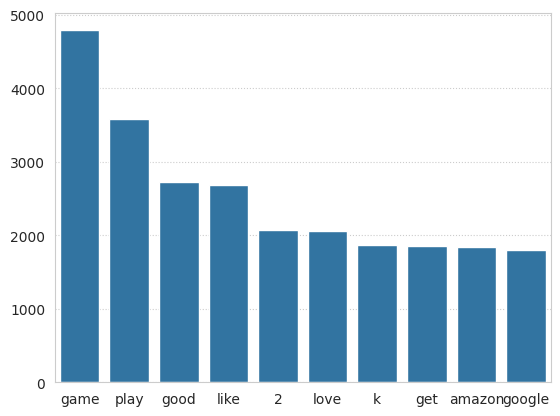

In [37]:
# Plotando um gráfico de barras

sns.barplot(x = words, y = count);

**Análise**

As palavras mais frequências do corpus denotam que a amosta selecionada pode ter forte relação com jogos e compras on-line.

**Verificação importante.**

Se o objetivo do modelo é ser aplicado de forma geral, deve-se retornar ao processo inicial de amostragem, e garantir que não haja segmentação no tema da na amostra.

A amostragem indicada para populações que contenham segmentação é a amostra extratificada.

No presente caso, tratando-se de dataset púbico, não é possível afirmar que todos os pressupostos foram atendidos.

Assim, o uso generalizado do modelo a ser treinado não é indicado.

**Identificação de linguagem**

De acordo com a documentação do administrador do dataset, os dados foram colhidos no twiiter, rede social de presença mundial. A identificação da linguagem predominante é imprescindível, e, será considerada requisito para utilização do modelo futuro.

Métodos possíveis:

- Confidence score com spaCY
- Com nltk
- Com modelos pré-treinados do hugging face

Utilizaremos o módulo nltk

In [38]:
# Identificando a linguagem de cada instância

df_total['language'] = df_total['text_processed'].map(language_identify)

In [39]:
# Visualizando linguagens
df_total['language'].unique()

array(['hinglish', 'catalan', 'albanian', 'english', 'danish', 'basque',
       'german', 'romanian', 'dutch', 'spanish', 'hungarian', 'finnish',
       'italian', 'french', 'azerbaijani', 'indonesian', 'uzbek',
       'swedish', 'slovene', 'portuguese', 'norwegian'], dtype=object)

In [40]:
# Visualizando frequências
pd.DataFrame(df_total['language'].value_counts()).reset_index()

,language,count
0,hinglish,18618
1,albanian,10107
2,english,1794
3,danish,786
4,catalan,575
5,dutch,341
6,german,287
7,french,287
8,romanian,187
9,azerbaijani,85


**Análise**

Entre os 3 mais frequências temos 2 variações de inglês, e albanês.

Primeiramente, é importante destacas que "hinglish" é um termo criado para identificar um fenômeno muito comum em linguagem de rede social, e, em resumo, a mistura de elementos de linguagem do inglês e do hindú (da Índia). Embora não seja reconhecidamente um idioma, é tão difundido que alguns modelos de linguagens, bem como os atuais fremeworks de pré-processamento foram treinados para reconhecê-lo.

Vamos analisar, contudo, a forte presença das instâncias identificadas com a língua albanesa.

In [41]:
# Visualizando amostra de 'henglish'
df_total[df_total['language'] == 'hinglish'].sample(5)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed,language
32919,Positive,Guys thanks team @Luis26098388 For making my f...,61,9,1,5.888889,9.000000,guy thank team luis26098388 make fortnite profile,hinglish
27234,Positive,All I’m looking forward to is the new Assassin...,73,15,1,3.866667,15.000000,m look forward new assassins creed game come,hinglish
17052,Negative,damn the ps5 only like 12 virgils . pic.twitt...,63,9,2,6.000000,4.500000,damn ps5 like 12 virgil pictwittercomxc1eyderaj,hinglish
10965,Irrelevant,Colt is trying it again. You guys ready for so...,86,16,3,4.437500,5.333333,colt try guy ready sweet sweet music shhhhhh l...,hinglish
21175,Negative,So I thought the modified shader would cause e...,209,41,2,4.121951,20.500000,think modify shader cause molly guy wingman ab...,hinglish


In [42]:
# Visualizando amostra de 'albanian'
df_total[df_total['language'] == 'albanian'].sample(5)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed,language
33551,Irrelevant,this is a joke even without actual players i h...,75,13,1,4.846154,13.0,joke actual player honestly believe sizcuhh,albanian
27734,Negative,disappointed that the gameplay has not been de...,59,10,1,5.000000,10.0,disappoint gameplay detect,albanian
17676,Irrelevant,You claim me and @kickzjilla tweet wild shit b...,89,14,1,5.428571,14.0,claim kickzjilla tweet wild shit tweet nonsens...,albanian
18876,Neutral,I just earned the [Horrific Vision of Orgimmar...,62,9,1,5.777778,9.0,earn horrific vision orgimmar achievement,albanian
6444,Neutral,The story is definitely funny and a great read...,100,19,2,4.210526,9.5,story definitely funny great read grab copy su...,albanian


Uma rápida observada na amostra das intâncias identificadas com linguagem 'albanian' permite concluir que o módulo nltk não fez um bom trabalho na identificação da linguagem.

Vamos criar um pipline com spacy, e ver como se sai.

In [43]:
# Instanciando nova classe para detecção
service = LanguageDetectorService()

In [44]:
df_total['language_spacy'] = df_total['text_processed'].map(service.return_language)

In [45]:
# Visualizando linguagens
df_total['language_spacy'].unique()

array(['da', 'nl', 'en', 'sv', 'UNKNOWN', 'ca', 'fi', 'es', 'af', 'no',
       'vi', 'et', 'cy', 'cs', 'so', 'ro', 'it', 'de', 'pt', 'fr', 'hr',
       'tl', 'lv', 'id', 'pl', 'sk', 'sl', 'tr', 'sq', 'lt', 'sw', 'hu'],
      dtype=object)

In [46]:
# Visualizando frequencias
summary_languages = pd.DataFrame(df_total['language_spacy'].value_counts()).reset_index()

In [47]:
summary_languages.head()

,language_spacy,count
0,en,25833
1,af,762
2,so,574
3,fr,550
4,nl,537


In [48]:
np.round(summary_languages[summary_languages['language_spacy'] == 'en']['count'].values / df_total.shape[0] * 100, 2)

array([77.26])

**Análise**

Utilizando o modelo do próprio spacy, temos que 77% das instâncias tiveram a linguagem identificada como inglês.

Vamos visualizar uma amostra, e, caso o match seja correspondente, seguiremos para a conclusão da parte 1 da EDA.

In [49]:
# Visualizando dados com linguagem identificada pelo spacy
df_total[df_total['language_spacy'] == 'en'].sample(10)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed,language,language_spacy
14584,Irrelevant,Best true sight as ever. Friendship make perfe...,53,9,2,5.000000,4.500000,good true sight friendship perfect team,hinglish,en
20855,Irrelevant,Had my mother picture her next to me in my Gam...,287,53,6,4.433962,8.833333,mother picture gamecube animal crossing lose m...,hinglish,en
4809,Neutral,I played this competitive quiz on Amazon - Try...,113,19,1,5.000000,19.000000,play competitive quiz amazon try luck chance ...,hinglish,en
9771,Irrelevant,Damn man! Every day Microsoft has a subject t...,81,16,2,4.062500,8.000000,damn man day microsoft subject feel good,danish,en
3375,Neutral,Wow I gotta believe it’s been 10 years since t...,80,14,1,4.785714,14.000000,wow get to believe 10 year introduce black op ...,hinglish,en
21132,Neutral,1. buy CS:GO or TF2 item off SCM. . 2. enjoy i...,182,41,11,3.463415,3.727273,1 buy csgo tf2 item scm 2 enjoy 1 week 3 wan...,hinglish,en
14694,Irrelevant,I did this trick couple months ago hahahaha. r...,62,10,2,5.300000,5.000000,trick couple month ago hahahaha ridiculously fun,albanian,en
12849,Negative,@2KSupport @NBA2K I purchased the nba 2k21 w f...,237,49,1,3.857143,49.000000,2ksupport nba2 k purchase nba 2k21 w forever e...,hinglish,en
17049,Neutral,when are all the games gonna start acting nice...,74,15,1,4.000000,15.000000,game go to start act nice hope get ps5,hinglish,en
463,Positive,Lil preview of a Mayan drawing I've been worki...,154,27,2,4.740741,13.500000,lil preview mayan drawing ve work lately ve sp...,hinglish,en


Visualizado, portanto, que a identificação está correta.

In [50]:
# Filtro por linguagem
df_total = df_total[df_total['language_spacy'] == 'en']

In [51]:
# Presistindo dados
#df_total.to_csv("../output/datasets/data.csv", index = False)

##### Análise exploratória - Part. 1 - **Conclusão**

1 - **Metadados como**:

  1.1. Dimensão do dataset após limpeza;
  
  1.2. Tipo de quantidade de atributos;
  
  1.3. Tema geral sobre as mensagens colhidas (indício)

2 - **Classes** (target- sentimentoss) presentes no dataset;

3 - **Análise estatística e gráfica**, por sentimento, de elementos descritivos como:

  3.1. Frequência de caracteres;
  
  3.2. Frequência de palavras;
  
  3.3. Frequência de sentenças;
  
  3.4. Média de palavras;
  
  3.5. Média de caracteres

4 - **Lingua predominante**.

5 - **Também pudemos averiguar a necessidade de alguns procedimentos prévios como**:

  5.1. Limpeza do texto
  
  5.2. Lematização
  
  5.3. Identificação e eliminação de outliers


A EDA inicial, portanto, foi bastante produtiva.

### **No proximo notebook, EDA - 2 (nível intermediário)**

**POS - Part-of-speech tagging: marcação de classes gramaticais**

Com a marcação, teremos cada token classificado de acordo com sua classe gramatical, determinando a estrutura sintática de uma sentença.

Esta identificação pode trazer atributos muito valiosos para análise, bem como para o treinamento do futuro modelo, e.g. uma sentença com classe negativa pode conter muito mais adjetivos do que uma sentença positiva ou neutra; ainda, a sua posição na sentença é um elemento tão valioso quanto a sua frequência.

**Para a tarefa em questão (modelo predidivo para classificação de sentimento), esperaremos, ao analisar o POS do corpus, uma composição rica em adjetivos e advérvios, e que haja variância entre estes por classe analisada.**

Os 3 métodos mais conhecidos são os dos módulos abaixo, cada um com suas vantagens e desvantagens. Mas, geralmente, pode-se esperar uma correlação entre precisão x quantidade de dados x recursos computacionais, que já é bastante conhecida no universo de ML.

Frameworks mais usados:

- NLTK (rule-based)
- TactBlob (rule-based)
- Spacy (statystical)



**Iniciando com o NLTK** que aplica o POS rule-based, cuja categorização é baseada no simples metch da palavra com um dicionário pré-definido.

Abaixo, legendas das tags tokenizadas no padrão universal:

NOUN (Substantivo)

VERB (Verbo)

ADJ (Adjetivo)

ADV (Advérbio)

PRON (Pronome)

DET (Determinante/Artigo)

ADP (Preposição/Postposição)

NUM (Numeral)

CONJ (Conjunção)

PRT (Partícula)

. (Pontuação)

X (Outras/Desconhecidas)

In [52]:
# Iniciando com NLTK

sample_words = df_total.text_processed[500:502]
sample_words

,text_processed
629,4 player local borderlands shop great weekend
630,sly borderlands haha mission demon dark mines ...


In [53]:
sample1 = sample_words[0:1, ].values[0]
sample2 = sample_words[1:, ].values[0]

In [54]:
# aplicando método NTLK na primeira amostra
pos_tag(word_tokenize(sample1), tagset='universal')

[('4', 'NUM'),
 ('player', 'NOUN'),
 ('local', 'ADJ'),
 ('borderlands', 'NOUN'),
 ('shop', 'VERB'),
 ('great', 'ADJ'),
 ('weekend', 'NOUN')]

In [55]:
# aplicando método NTLK na seegunda amostra
pos_tag(word_tokenize(sample2), tagset='universal')

[('sly', 'ADV'),
 ('borderlands', 'VERB'),
 ('haha', 'ADJ'),
 ('mission', 'NOUN'),
 ('demon', 'NOUN'),
 ('dark', 'NOUN'),
 ('mines', 'NOUN'),
 ('moria', 'NOUN'),
 ('nice', 'ADV')]

**Análise**

Na segunda amostra podemos ver baixa acurácia na marcação de tags.

Respectivamente, a marcação correta seria:

sly -> ADJ

borderlands -> NOUM

haha -> PRT

nice -> ADJ

Observe que, para "sly" e "nice" podemos flexibilizar um pouco a transição de ADV -> ADJ, pois o processo de lematização truncou as palavras para sua raiz. Entretanto, nãoé o caso com as demais.

**Continuando com o spacy** que aplica o POS no modo estatístico. Utiliza um modelo pré-treinado (OntoNotes 5 corpus). Espera-se uma acurácia maior deste método.

Vamos usar o mesmo padrão de tags, conforme [documentação](https://spacy.io/api/token#attributes) do módulo spacy, o [POS Tag Universal](https://universaldependencies.org/u/pos/)

In [56]:
# Realizando tokenização da sentença 1
doc = dicionario(sample1)
for token in doc:
  print(token.text, '----', token.pos_)

4 ---- NUM
player ---- NOUN
local ---- ADJ
borderlands ---- NOUN
shop ---- PROPN
great ---- ADJ
weekend ---- NOUN


In [57]:
# Realizando tokenização da sentença 2
doc = dicionario(sample2)
for token in doc:
  print(token.text, '----', token.pos_)

sly ---- ADJ
borderlands ---- PROPN
haha ---- PROPN
mission ---- NOUN
demon ---- PROPN
dark ---- PROPN
mines ---- NOUN
moria ---- PROPN
nice ---- ADJ


**Análise**

Como esperado, o modelo do módulo spacy teve melhor desempenho.

Nas palavras sly e nice apresentou a classificação correta, e, em borderlands e haha, por exemplo, embora não tenha sido total precisa, chegou mais perto do que a classificação anterior, realizada pelo NLTK.

**Aplicando ao corpus** - seguiremos com spacy

Porque é importante aplicar POS ao corpus?

Para conhecer as limitações do nosso futuro modelo. O corpus será o vocabulário do nosso tokenizador. Na prática - e especialmente em ambientes informais - as pessoas incorporam muitas gírias, ditados, palavras extrageiras e expressões não possuem correspondência com o vocabulário formal de uma língua.

Desta forma, usar um vocabulário do mundo dos jogos online para classificar sentimento de notícias ecnômicas, por exemplo, resultará em muitos erros de previsão.

Não é demais ressaltar, não era nossa pretensão limitar a aplicação do modelo; entratanto, é um dos objetivos da EDA entender o conjunto de dados, inclusive, suas limitações.

Acima, pudemos concluir, pela análise de frequẽncia das palavras do corpus, que a amostra colhida para o treinamento do modelo tem forte ligação com os temas compras on-line e jogos.



Abaixo, faremos a aplicação da técnica em todo *corpus*.

In [58]:
# passo 1 - preparação do corpus
corpus[:10]

['get',
 'borderland',
 'murder',
 'come',
 'border',
 'kill',
 'get',
 'borderland',
 'kill',
 'come']

In [59]:
# aplicando tokenização ao corpus
step = 5000
result = []

for idx in tqdm(range(0, len(corpus), step)):
  if idx > len(corpus):
    break

  doc = dicionario(" ".join(corpus[idx:idx+step]))

  result.append([token.pos_ for token in doc])

100%|██████████| 65/65 [00:53<00:00,  1.21it/s]


In [60]:
df_pos = pd.DataFrame({
    "pos" : [pos for doc in result for pos in doc]
})

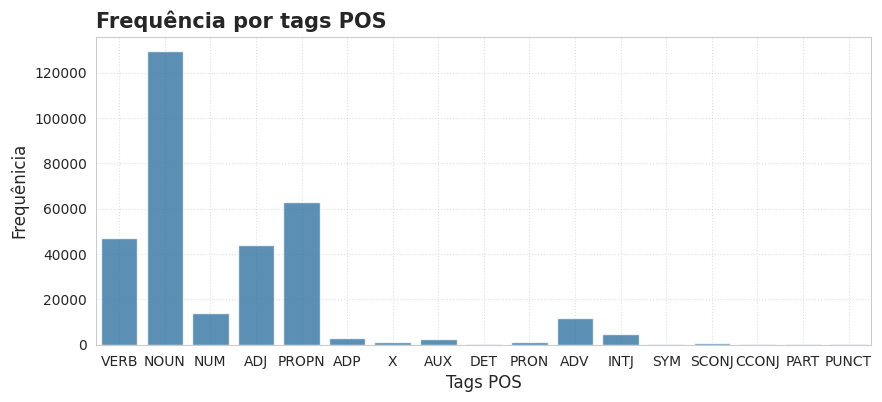

In [61]:
plt.figure(figsize=(10, 4))

chart = sns.countplot(data=df_pos, x="pos", alpha = .8)

# confiturando o ambiente
sns.set_style('whitegrid',
 {'grid.linestyle' : ':',
  'grid.color':'1'})
chart.grid(alpha=.6)
sns.set(font_scale=.9)
chart.set_ylabel("Frequênicia", fontsize=12)
chart.set_xlabel("Tags POS", fontsize=12)
chart.tick_params(axis = 'x', width = 2)


chart.text(s = "Frequência por tags POS",
           fontweight = 'bold',
           fontsize = 15,
           x = -.5,
           y = 140000)

plt.show()

**Análise**

Advérbrios (ADP) e adjetivos (ADJ) estão com a frequência menor do que o esperado. Tendo em vista que pretendemos capturar sentimentos, espera-se um texto mais opnativo e expressivo. O que temos, por outro lado, é um corpus informativo e descritivo.

Nosso corpus traz mais sobre lugares, pessoas, marcas, assuntos, etc., do que opniões.

Este desafio é inerente á análise de sentimento em textos de redes sociais. Eventualmente, o modelo terá que capturar o sentimento levando em conta o contexto, ou combinações entre Tags.

**Matriz POS**

Vamos calular os TOP 20 bigramas e entender como se relacionam.

In [62]:
# extraindo tags
tags = [pos for doc in result for pos in doc]

# Calculando bigramas
df_ngrams = pd.DataFrame(Counter(list(ngrams(tags, 2))).most_common(20), columns = ['from', 'values'])

df_ngrams[['from', 'to']] = pd.DataFrame(df_ngrams['from'].to_list(), index=df_ngrams.index)

matriz_resumida = df_ngrams.pivot(index = 'from', columns = 'to', values = 'values').fillna(0).astype(int)


**VIsualizando**

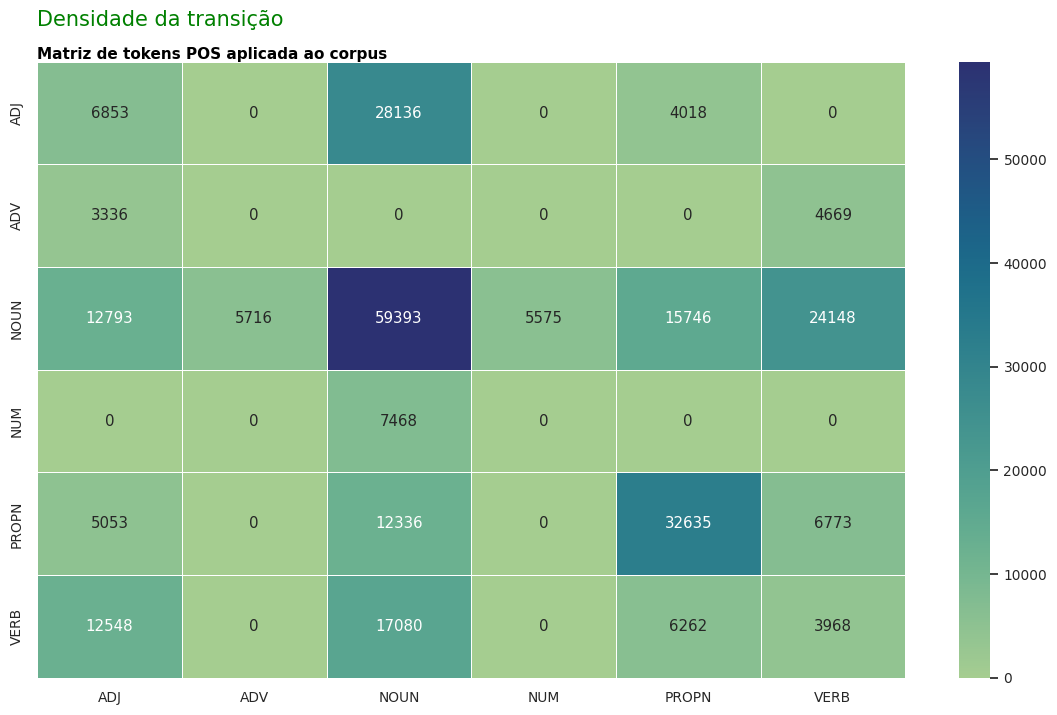

In [63]:
plt.figure(figsize=(14, 8))

chart = sns.heatmap(matriz_resumida,
                    annot=True,
                    fmt='d',
                    linewidths=.5,
                    cmap = 'crest')

sns.set_style('whitegrid')

chart.set_ylabel(ylabel='')
chart.set_xlabel(xlabel='')

chart.text(s = 'Densidade da transição',
           x = 0, y = -.35,
           fontsize = 15, color = 'green')

chart.text(s = 'Matriz de tokens POS aplicada ao corpus',
           x = 0, y = -.03,
           fontsize = 11, color = 'black', fontweight = 'bold');

**Análise**

A matriz de tokens em transição comprova o que visualizamos no gráfico de barras; as conexões entre adjetivos/advérbios são baixas se comparadas às conexões entre pronomes, substantivos e seus relacionamentos.

Porque isso é importante? pode comprometer o aprendizado, em um primeito momento, e, a generalização deste aprendizado, num segundo momento.

O invés de aprender, por exemplo, que o sentimento positivo tem grande relacionamento com adjetivos (bom, ótimo, surpreso, excelente), o modelo tentará encontra relacionamentos que se estabecem através de nomes próprios compostos  ou por substantivos compostos (e.g. Microsoft Xbox/NOUM -> NOUM, xbox series/NOUM -> NOUM).

Observe que, em ambos os casos de exemplo, quando o algoritmo for aplicado em novos dados, decidir que o substantivo Microsoft está sempre associado à algo bom ou ruim, por si sé, é um erro.

Em um ambiente de produção, haveria uma séria recomendação para que o projeto retorne à fase de amostragem dos dados, com a coleta de dados que suporte o objetivo do modelo.

**Análise de N-gramas.**

Vamos analisar bi-gramas e tri-gramas

In [64]:
bigrams = Counter(list(ngrams(corpus, 2, pad_right=True, right_pad_symbol='</s>'))).most_common(10)
trigrams = Counter(list(ngrams(corpus, 3, pad_right=True, right_pad_symbol='</s>'))).most_common(10)

**Visualizando bigramas**

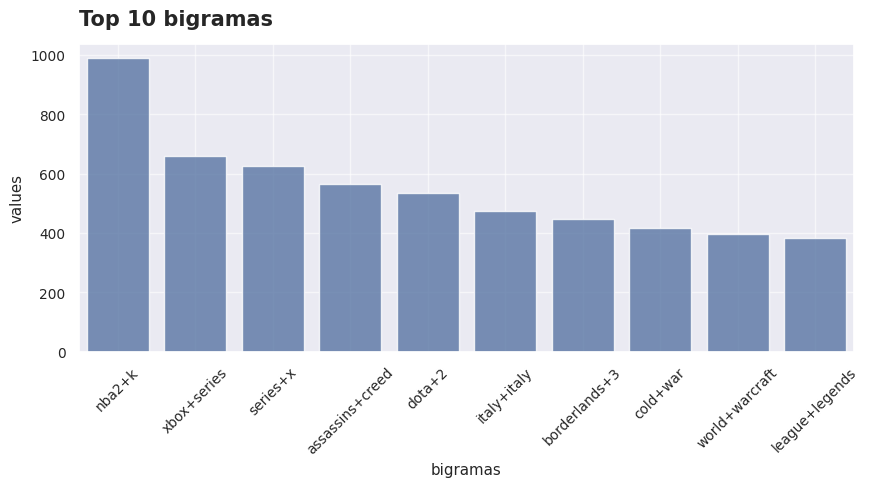

In [91]:
df_bigramas = pd.DataFrame(bigrams, columns = ['bigramas', 'values'])
df_bigramas['bigramas'] = df_bigramas['bigramas'].apply(lambda x: '+'.join(x))
plt.figure(figsize=(10, 4))

chart = sns.barplot(data=df_bigramas, x="bigramas", y = 'values', alpha = .8)

# confiturando o ambiente
sns.set_style('whitegrid',
 {'grid.linestyle' : ':'})

chart.grid(alpha=.6)

sns.set(font_scale=.9)

plt.xticks(rotation = 45)

chart.text(s = "Top 10 bigramas",
           fontweight = 'bold',
           fontsize = 15,
           x = -.5,
           y = 1100)

plt.show()

**Análise**

Os bigramas acima, são nossos tokens originais, sobre os quais foram calculadosas tags POS. Acima temos os top 10 bigramas, e, demonstram como acontece o grande número de sequências NOUM -> NOUM que vimos na matriz POS.

**Visualizando trigramas**

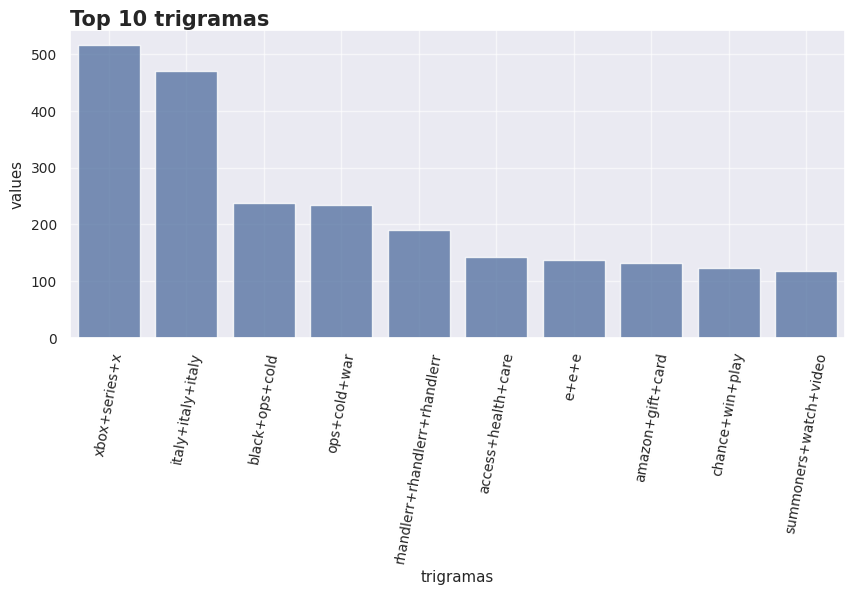

In [94]:
df_trigramas = pd.DataFrame(trigrams, columns = ['trigramas', 'values'])
df_trigramas['trigramas'] = df_trigramas['trigramas'].apply(lambda x: '+'.join(x))
plt.figure(figsize=(10, 4))

chart = sns.barplot(data=df_trigramas, x="trigramas", y = 'values', alpha = .8)

# confiturando o ambiente
sns.set_style('whitegrid',
 {'grid.linestyle' : ':'})

chart.grid(alpha=.6)

sns.set(font_scale=.9)

plt.xticks(rotation = 80)

chart.text(s = "Top 10 trigramas",
           fontweight = 'bold',
           fontsize = 15,
           x = -.5,
           y = 550)

plt.show()

**Análise**

Os top 10 trigramas não apresentam nada de novo. De fato, temos um texto informativo, falando sobre pessoas, coisas aleatórias, marcas, etc.

##### Análise exploratória - Part. 2 - **Conclusão**

Neste ponto, antes de elencar os pontos chaves desta etapa de EDA, é interessante notar que a marcação de classes gramaticais e a análise de ngrams demonstra que, possivelmente, ao treinarmos os modelos, os modelos que tem a capacidade de capturar contexto terão melhor desempenho do que os que não tem.

Isto porque, o dataset é pobre de features, denotando natureza diversa da indicada para a classificação de sentimentos. Conforme já informado, em modelos mais simples, teremos dificuldade de aprendizado, e, nos mais complexos, dificuldade na generalização.

Abaixo, os principais itens de contribuição da EDA Part. 2 (nível intermediário).

1 - **POS**:

  1.1. Escolha do módulo (NLTK ou space);
  
  1.2. Escolha do método (tule-based ou statistyycal);
  
  1.3. Aplicação ao *corpus*

  1.4. Análise univariada de das tags POS;

  1.5. Análise da matriz de bigramas, das tags POS;

2 - **Ngramas** (dos tokens);

  2.1. Análise de bigramas dos tokens;

  2.2. Anállise de  trigramdas dos tokens.

A EDA inicial, portanto, foi bastante produtiva.

3 - **Também pudemos concluir**:

  5.1. Confirmando os indícios da etada de EDA anterior, o texto se mostra pouco propenso à análise de sentimentos por métodos tradicionais;
  
  5.2. O baixo relacionamento das tags com as tags ADJ e ADV
  
  5.3. A possível necessidade de captura do contexto, com modelos mais complexos, devido à característica pouco opnativa dos textos.


A EDA intermediária, portanto, foi produtiva e complementar da primeira etapa.